In [1]:
!pip3 install pathlib
!pip3 install numpy
!pip3 install pandas
!pip3 install multiprocess
!pip3 install matplotlib
!pip3 install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import multiprocess as mp
import matplotlib.pyplot as plt
import seaborn as sns

## Load the data: Huge data using multi-thread processing technique

In [3]:
path = Path("../data/")
out_path = str(path / "endomondoHR_proper.json")

def process(line):
    return eval(line)

pool = mp.Pool(5) 
with open(out_path, 'r') as f:
    data = pool.map(process, f)
pool.close()
pool.join()

In [4]:
df = pd.DataFrame(data)
df.head()

,longitude,altitude,latitude,sport,id,heart_rate,gender,timestamp,url,userId,speed
0,"[24.64977040886879, 24.65014273300767, 24.6509...","[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....","[60.173348765820265, 60.173239801079035, 60.17...",bike,396826535,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",male,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915,"[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3..."
1,"[24.649855233728886, 24.65015547350049, 24.650...","[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....","[60.173247596248984, 60.17320962622762, 60.172...",bike,392337038,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",male,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915,"[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30..."
2,"[24.64995657093823, 24.650197718292475, 24.651...","[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....","[60.17326201312244, 60.173205351457, 60.172969...",bike,389643739,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",male,"[1407858459, 1407858466, 1407858478, 140785849...",https://www.endomondo.com/users/10921915/worko...,10921915,"[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3..."
3,"[24.649874344468117, 24.650242729112506, 24.65...","[28.6, 29.4, 29.4, 29.4, 28.0, 27.0, 25.2, 23....","[60.173286236822605, 60.17323946580291, 60.173...",bike,386729739,"[99, 105, 113, 109, 112, 116, 116, 114, 114, 1...",male,"[1407432042, 1407432048, 1407432056, 140743206...",https://www.endomondo.com/users/10921915/worko...,10921915,"[7.4988, 15.4008, 17.8668, 21.5712, 24.1416, 3..."
4,"[24.64979832060635, 24.64992195367813, 24.6500...","[32.0, 32.0, 32.0, 35.8, 36.2, 36.2, 36.2, 36....","[60.17329327762127, 60.17327332869172, 60.1732...",bike (transport),383186560,"[110, 113, 114, 116, 123, 126, 129, 135, 137, ...",male,"[1406909434, 1406909436, 1406909437, 140690943...",https://www.endomondo.com/users/10921915/worko...,10921915,NaN


In [5]:
# Overall columns of dataframe
display(df.columns)
# Counting missing values in the dataframe
display(df.isna().sum())
# See how many data points are recorded in each workout
display(len(df.loc[0, 'speed']))
# View the data type for each column
display(df.dtypes)

Index(['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate',
       'gender', 'timestamp', 'url', 'userId', 'speed'],
      dtype='object')

longitude          0
altitude           0
latitude           0
sport              0
id                 0
heart_rate         0
gender             0
timestamp          0
url                0
userId             0
speed         136110
dtype: int64

500

longitude     object
altitude      object
latitude      object
sport         object
id             int64
heart_rate    object
gender        object
timestamp     object
url           object
userId         int64
speed         object
dtype: object

- Based on the above summary and statistics, we found that there's a lot of invalid data in speed column. As the dataframe is already huge enough, we decided to drop those NaN rows to reduce the overall size and preserve data consistency
- Based on the columns above, we found that columns like `longitude`, `latitude`, `url` may not be useful for our research questions. Therefore, we decided to drop those columns

In [6]:
# We will not focus on longitude, latitude, and url in our research questions
df = df.dropna().drop(['longitude', 'latitude', 'url'], axis=1)
df.head()

,altitude,sport,id,heart_rate,gender,timestamp,userId,speed
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",bike,396826535,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",male,"[1408898746, 1408898754, 1408898765, 140889877...",10921915,"[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3..."
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",bike,392337038,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",male,"[1408221682, 1408221687, 1408221699, 140822170...",10921915,"[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30..."
2,"[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....",bike,389643739,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",male,"[1407858459, 1407858466, 1407858478, 140785849...",10921915,"[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3..."
3,"[28.6, 29.4, 29.4, 29.4, 28.0, 27.0, 25.2, 23....",bike,386729739,"[99, 105, 113, 109, 112, 116, 116, 114, 114, 1...",male,"[1407432042, 1407432048, 1407432056, 140743206...",10921915,"[7.4988, 15.4008, 17.8668, 21.5712, 24.1416, 3..."
6,"[24.0, 24.0, 24.0, 21.0, 18.6, 17.4, 17.4, 17....",bike (transport),381185226,"[118, 118, 119, 120, 122, 124, 126, 129, 133, ...",male,"[1406647079, 1406647080, 1406647082, 140664708...",10921915,"[7.218, 9.8208, 14.3532, 16.2972, 20.1276, 20...."


sport
bike                       17093
run                        11532
bike (transport)            1047
mountain bike               1012
indoor cycling               750
walk                         102
fitness walking               30
cross-country skiing          29
core stability training       21
roller skiing                 19
skate                         12
orienteering                  11
kayaking                      10
hiking                         4
horseback riding               1
Name: count, dtype: int64

/var/folders/t2/t_vlyyqs1fx_lsym71tgvwpm0000gn/T/ipykernel_9213/110845249.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sport_type_stat_df['sport'], rotation=40, ha="right")


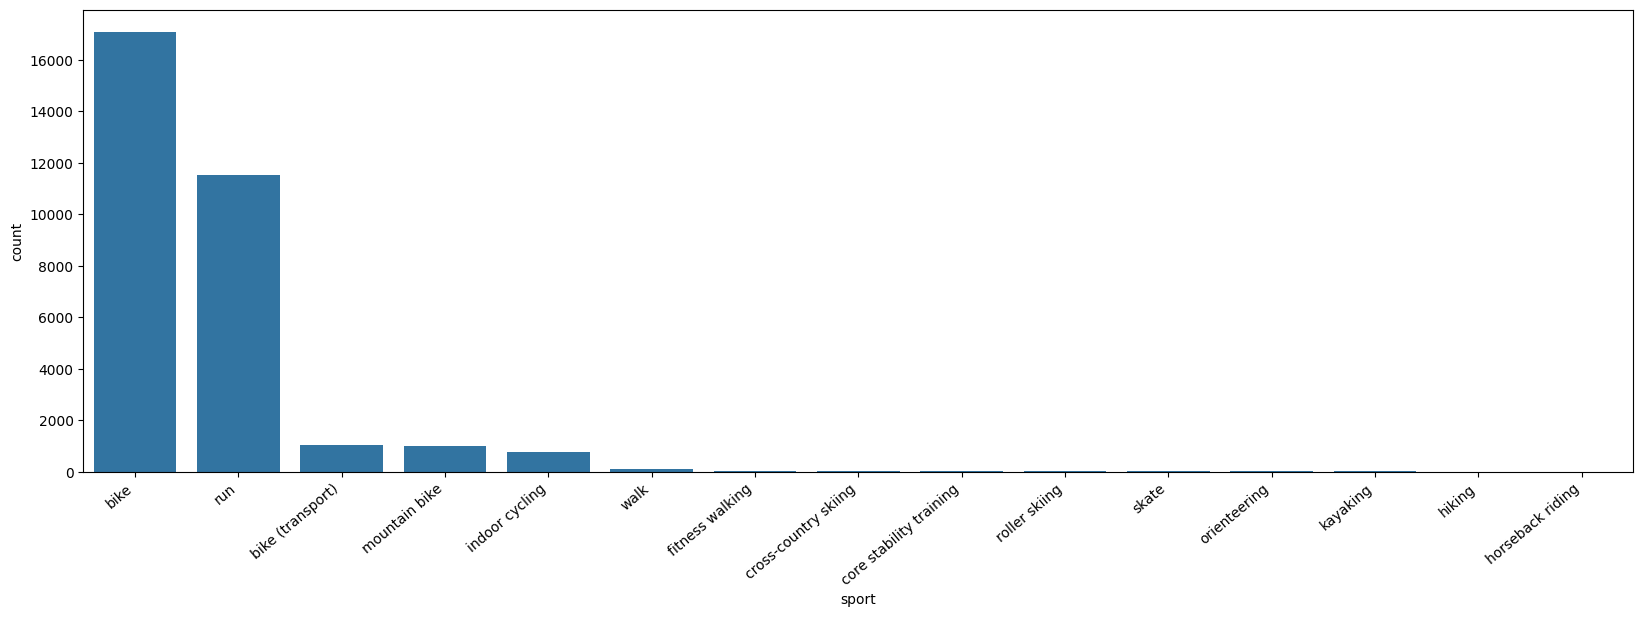

In [7]:
# View how many types of sport and the number of each sport accordingly
display(df['sport'].value_counts())
plt.figure(figsize=(20,6))
sport_type_stat = df['sport'].value_counts()
sport_type_stat_df = sport_type_stat.reset_index()
sport_type_stat_df.columns = ['sport', 'count']
ax = sns.barplot(data=sport_type_stat_df, x='sport', y='count')
ax.set_xticklabels(sport_type_stat_df['sport'], rotation=40, ha="right")
plt.show()

From the statistics above, we see that there's a huge bias in the number of samples collected for each type of sport. However, the data is already sampled by the institution so that we don't have the ability to re-sample them. Therefore, we decided to use sports ranging from `bike` to `walk` for future model building. However, for the EDA purpose below, we will include all types of sport to get a general sense of data

gender
male       29519
female      2035
unknown      119
Name: count, dtype: int64

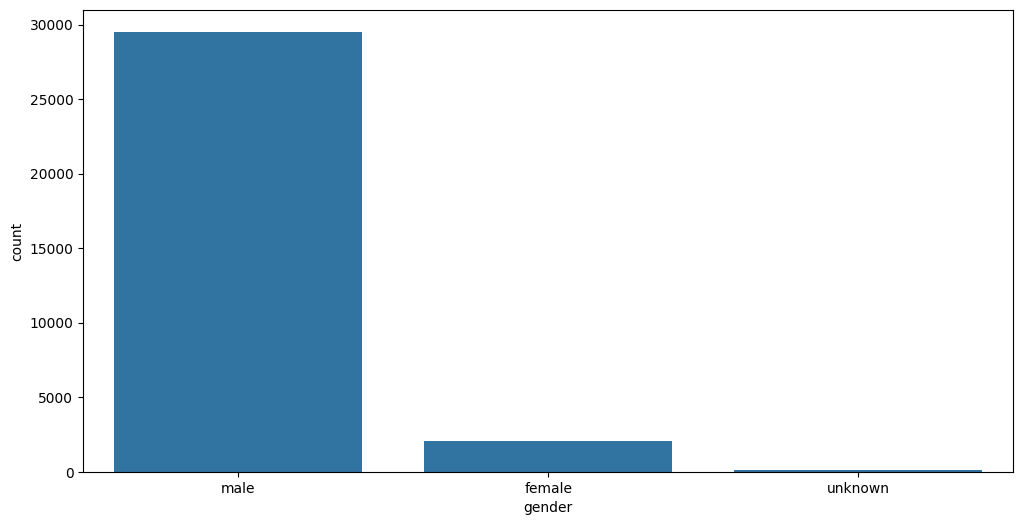

In [8]:
# View gender bias in the sampling
display(df['gender'].value_counts())
plt.figure(figsize=(12,6))
gender_stat = df['gender'].value_counts()
gender_stat_df = gender_stat.reset_index()
gender_stat_df.columns = ['gender', 'count']
ax = sns.barplot(data=gender_stat_df, x='gender', y='count')
plt.show()

From the statistics above, we see that there's also a huge bias in the number of samples collected for each gender. Again, we are not able to re-sample the data. Therefore, we decided to build completely independent models for `male` and `female` in future modeling process and disregard `unknown`

## Create boxplot to describe the heart rate performance for each type of sport, help with the recommendation

In [9]:
def generate_sport_heart_rate_df(sport_type, gender):
    '''
    Since values in original dataframe are stored in list, we can create individual dataframes for each sport type
    to record the heart rate for plotting purpose
    '''
    heart_rate_dict = {}
    for index, row in df.iterrows():
        if row['sport'] == sport_type and row['gender'] == gender:
            if sport_type not in heart_rate_dict:
                heart_rate_dict[sport_type] = []
            heart_rate_dict[sport_type].extend(row['heart_rate'])

    df_heart_rate_by_type = pd.DataFrame.from_dict(heart_rate_dict).rename(columns={sport_type:'heart rate'})
    df_heart_rate_by_type['type'] = sport_type
    df_heart_rate_by_type['gender'] = gender
    return df_heart_rate_by_type

In [10]:
sport_types = df['sport'].unique()
sport_types

array(['bike', 'bike (transport)', 'run', 'kayaking', 'indoor cycling',
       'mountain bike', 'orienteering', 'core stability training', 'walk',
       'cross-country skiing', 'fitness walking', 'roller skiing',
       'skate', 'hiking', 'horseback riding'], dtype=object)

In [11]:
# Generate heart rate dataframe for male
sport_type_dfs_male = []
for sport in sport_types:
    sport_type_dfs_male.append(generate_sport_heart_rate_df(sport, 'male'))

In [12]:
# Generate heart rate dataframe for female
sport_type_dfs_female = []
for sport in sport_types:
    sport_type_dfs_female.append(generate_sport_heart_rate_df(sport, 'female'))

/var/folders/t2/t_vlyyqs1fx_lsym71tgvwpm0000gn/T/ipykernel_9213/2871948402.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


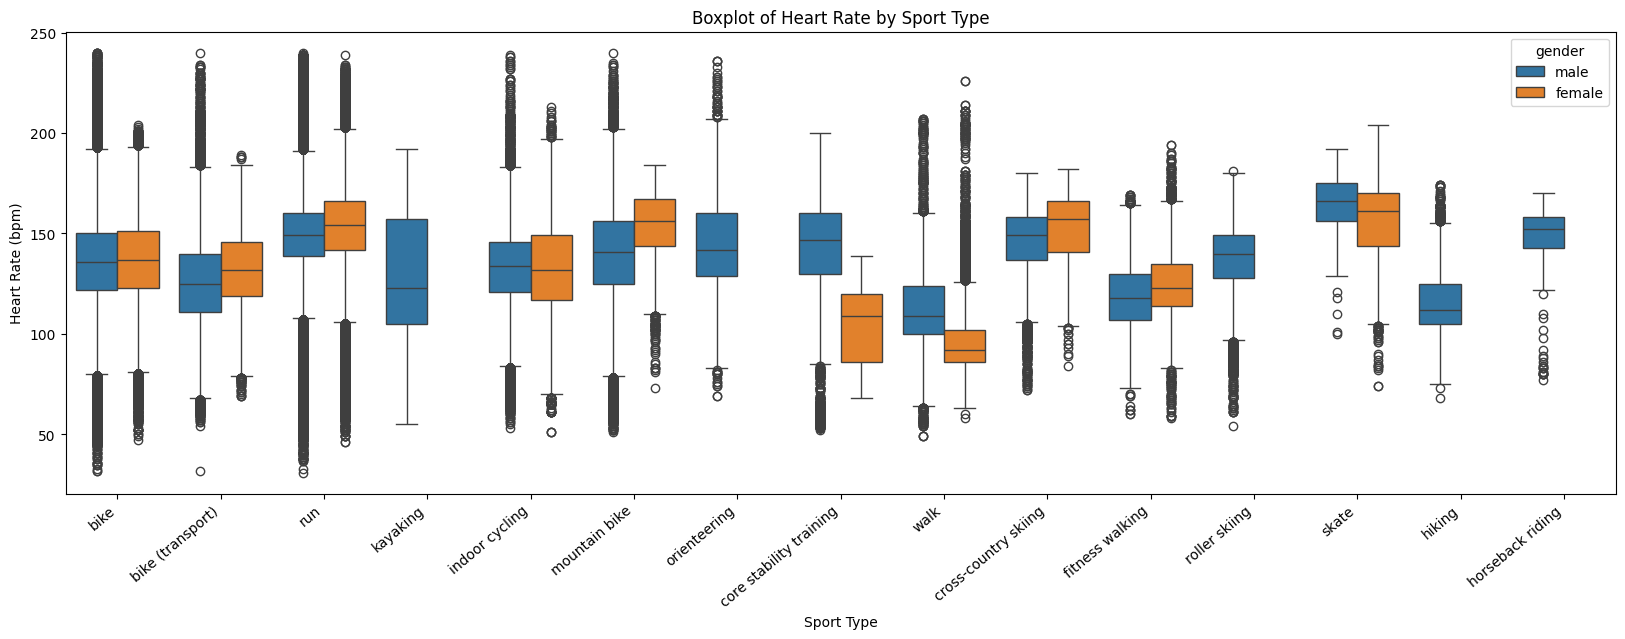

In [13]:

# Create side-by-side boxplot to indicate the heart rate distribution of each type sport for both male and female
df_sport_heart_rate = pd.concat(sport_type_dfs_male+sport_type_dfs_female)
plt.figure(figsize=(20, 6))
ax = sns.boxplot(data=df_sport_heart_rate, x='type', y='heart rate', hue='gender')
ax.set_xlabel('Sport Type')
ax.set_ylabel('Heart Rate (bpm)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Boxplot of Heart Rate by Sport Type')
plt.show()

In the above graph, we visualize the heart rate distribution of each sport differentiate by gender. Thus, we are able to use the information retrieved to recommend to the users corresponding sport type based on their target calories burnt.

## Create 15 plots for each sport(timestamp VS speed, timestamp vs heart_rate) to visualize the change pattern

In [14]:

def plot_sport_data(sport, df, ax1, ax2):
    filtered_df = df[df['sport'] == sport]
    
    if filtered_df.empty:
        return
    
    first_row = filtered_df.iloc[0]
    
    # Create a new dataframe from the first row
    new_df = pd.DataFrame([first_row])
    new_df = new_df[['timestamp', 'heart_rate', 'speed']]
    
    # Explode the dataframe
    exploded_df = new_df.explode('timestamp').reset_index(drop=True)
    exploded_df['heart_rate'] = new_df['heart_rate'].explode().reset_index(drop=True)
    exploded_df['speed'] = new_df['speed'].explode().reset_index(drop=True)
    exploded_df['timestamp'] = pd.to_datetime(exploded_df['timestamp'], unit='s')
    exploded_df['time_diff'] = exploded_df['timestamp'].diff().dt.total_seconds()

    time_diff_threshold = 20
    # guarentee the resulted df has at least 100 rows
    while True:
        filtered_df = exploded_df[(exploded_df['time_diff'] >= time_diff_threshold) | (exploded_df['time_diff'].isna())]
        if len(filtered_df) >= 100 or time_diff_threshold <= 0:
            break
        time_diff_threshold -= 1

    filtered_df = filtered_df.drop(columns=['time_diff'])

    
    sns.lineplot(data=filtered_df, x='timestamp', y='speed', ax=ax1, label='Speed', color='blue')
    ax1.set_ylabel('Speed', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(['Speed'], loc='upper left')

    sns.lineplot(data=filtered_df, x='timestamp', y='heart_rate', ax=ax2, label='Heart Rate', color='red')
    ax2.set_ylabel('Heart Rate', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(['Heart Rate'], loc='upper right')


    ax1.set_title(sport)

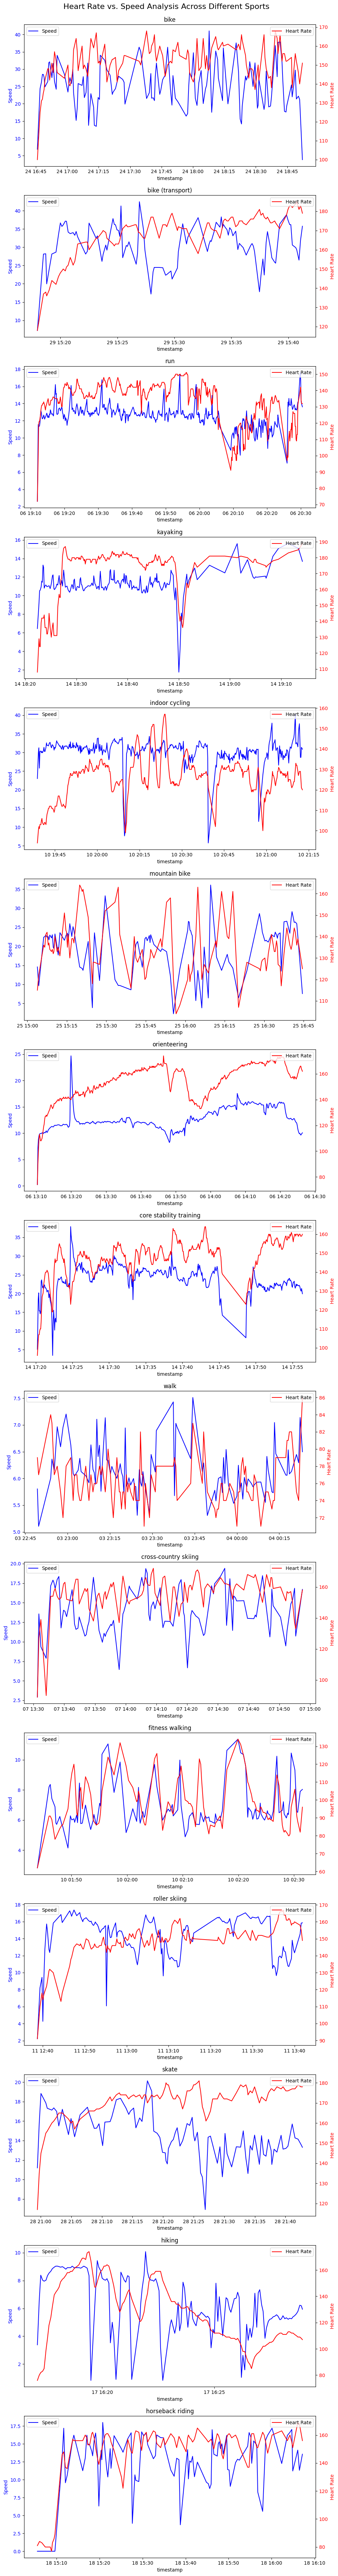

In [15]:
# Create subplots with 1 column and a number of rows equal to the number of sports
fig, axes = plt.subplots(nrows=len(sport_types), ncols=1, figsize=(10, 5 * len(sport_types)))  # Adjusted figsize for better layout
fig.tight_layout(pad=4.0)

for i, sport in enumerate(sport_types):
    plot_sport_data(sport, df, axes[i], axes[i].twinx())

fig.suptitle("Heart Rate vs. Speed Analysis Across Different Sports", fontsize=16, y=1)
plt.show()

In the above graph, we display the workout pattern of `speed` and `heart rate` for each type of sport in a fixed time interval to get a sense of how these two variable correlate with each other during a workout process